In [1]:
import numpy as np
import io
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import files
uploaded = files.upload()


Saving spam.csv to spam.csv


In [3]:
import pandas as pd
import io

spam_data = pd.read_csv(io.BytesIO(uploaded['spam.csv']))
spam_data.head()

,Mail,Annotator 1,Annotator 2
0,I wanted to send you some money for your upcom...,0,0
1,Top job opportunities await you! Apply now for...,1,0
2,Final Reminder! Your special discount code exp...,1,1
3,The updated project files are attached for you...,0,0
4,Your subscription to our newsletter has been a...,0,0


# Visualization

In [4]:
#spam vs no-spam annotator 1
spam_data['Annotator 1'].value_counts()

,count
Annotator 1,
0,75
1,75




*   0: No-Spam
*   1: Spam



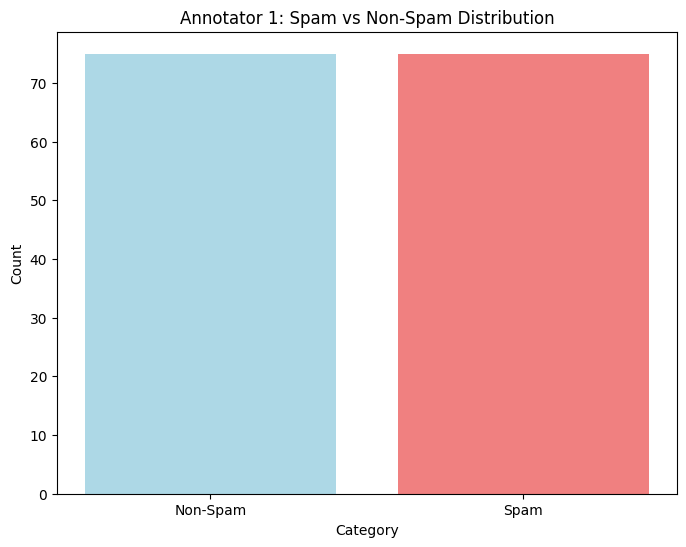

In [5]:
# Data
categories = ["Non-Spam", "Spam"]
values = [75, 75]

# Plot
plt.figure(figsize=(8, 6))
plt.bar(categories, values, color=["lightblue", "lightcoral"])
plt.title("Annotator 1: Spam vs Non-Spam Distribution")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

In [6]:
#spam vs no-spam annotator 1
spam_data['Annotator 2'].value_counts()

,count
Annotator 2,
0,78
1,72




*   0: No-Spam
*   1: Spam




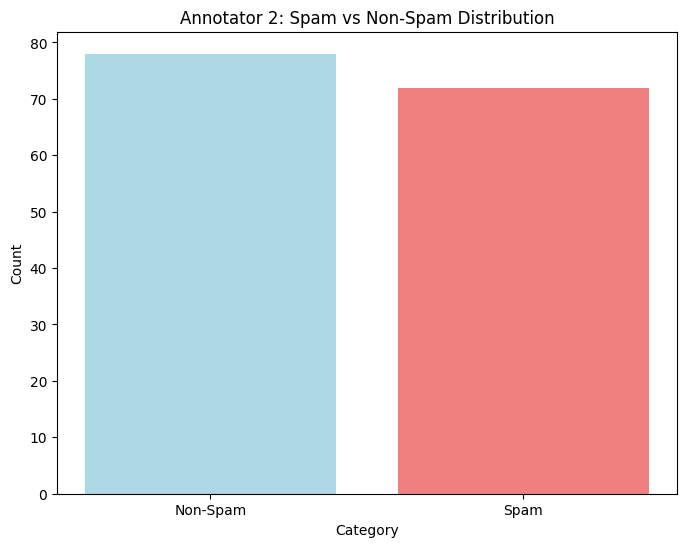

In [7]:
# Data
categories = ["Non-Spam", "Spam"]
values = [78, 72]

# Plot
plt.figure(figsize=(8, 6))
plt.bar(categories, values, color=["lightblue", "lightcoral"])
plt.title("Annotator 2: Spam vs Non-Spam Distribution")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

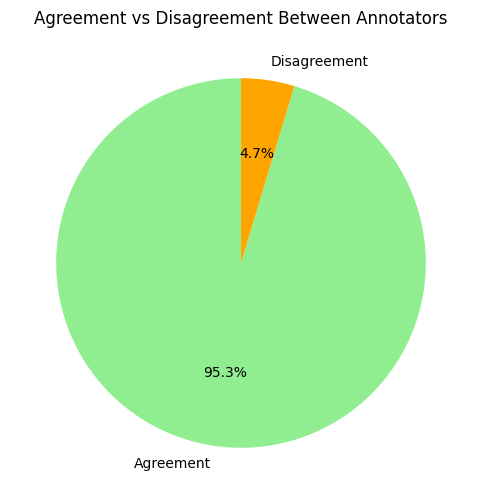

In [8]:
# Calculate agreement and disagreement between both Annotators
agreement_counts = (spam_data['Annotator 1'] == spam_data['Annotator 2']).value_counts()

# Plot Agreement vs Disagreement
plt.figure(figsize=(8, 6))
plt.pie(
    agreement_counts,
    labels=["Agreement", "Disagreement"],
    autopct='%1.1f%%',
    startangle=90,
    colors=["lightgreen", "orange"]
)
plt.title("Agreement vs Disagreement Between Annotators")
plt.show()

In [35]:
from sklearn.metrics import cohen_kappa_score

# Assuming the dataset has columns 'Annotator 1' and 'Annotator 2'
annotator_1 = spam_data['Annotator 1']
annotator_2 = spam_data['Annotator 2']

# Calculate Cohen's Kappa
kappa_score = cohen_kappa_score(annotator_1, annotator_2)

print(f"Cohen's Kappa: {kappa_score:.2f}")

Cohen's Kappa: 0.91


# Preprocessing

In [9]:
df=spam_data.drop(['Annotator 2'],axis=1)

In [10]:
df = df.rename(columns={'Annotator 1': 'Spam'})
df.head()

,Mail,Spam
0,I wanted to send you some money for your upcom...,0
1,Top job opportunities await you! Apply now for...,1
2,Final Reminder! Your special discount code exp...,1
3,The updated project files are attached for you...,0
4,Your subscription to our newsletter has been a...,0


In [11]:
df['Spam'] = df['Spam'].astype(int)

In [12]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

In [13]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


In [15]:
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

In [16]:
df['Mail'] = df['Mail'].apply(preprocess_text)

In [17]:
#Train-Test Split
X = df['Mail']
y = df['Spam']

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [20]:
#Vectorize Text Data
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [21]:
# Output shapes for verification
print("X_train shape:", X_train_vectorized.shape)
print("X_test shape:", X_test_vectorized.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (120, 845)
X_test shape: (30, 845)
y_train shape: (120,)
y_test shape: (30,)


In [22]:
# Save the preprocessed data for fine-tuning
np.savez('preprocessed_data.npz',
         X_train=X_train_vectorized.toarray(),
         X_test=X_test_vectorized.toarray(),
         y_train=y_train,
         y_test=y_test)

# Fine-Tuning and Accuracy Calculation

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [25]:
# Load preprocessed data
data = np.load('preprocessed_data.npz')
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

In [26]:
#Define the Neural Network Model
model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],), activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
    ])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
#Compile the Model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [28]:
# Train the Model
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=10,
                    batch_size=32,
                    verbose=1)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 260ms/step - accuracy: 0.4609 - loss: 0.6960 - val_accuracy: 0.4583 - val_loss: 0.6959
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5768 - loss: 0.6866 - val_accuracy: 0.4583 - val_loss: 0.6910
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7161 - loss: 0.6797 - val_accuracy: 0.4583 - val_loss: 0.6861
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7995 - loss: 0.6676 - val_accuracy: 0.5000 - val_loss: 0.6811
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8359 - loss: 0.6555 - val_accuracy: 0.5000 - val_loss: 0.6751
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8919 - loss: 0.6434 - val_accuracy: 0.5833 - val_loss: 0.6675
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8984 - loss: 0.6312 - val_accuracy: 0.6250 - val_loss: 0.6579
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9518 - loss: 0.6200 - val_accuracy: 0.6667 - val_loss: 0.6451

In [29]:
# Evaluate the Model
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


In [30]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.77


In [31]:
# Step 5: Detailed Evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.70      1.00      0.82        16
           1       1.00      0.50      0.67        14

    accuracy                           0.77        30
   macro avg       0.85      0.75      0.74        30
weighted avg       0.84      0.77      0.75        30



In [32]:
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Confusion Matrix:
[[16  0]
 [ 7  7]]


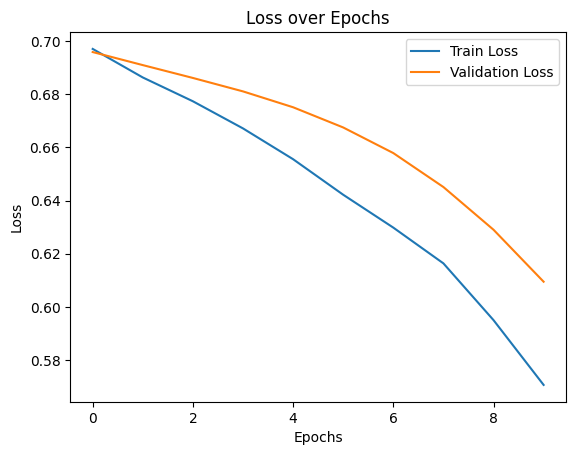

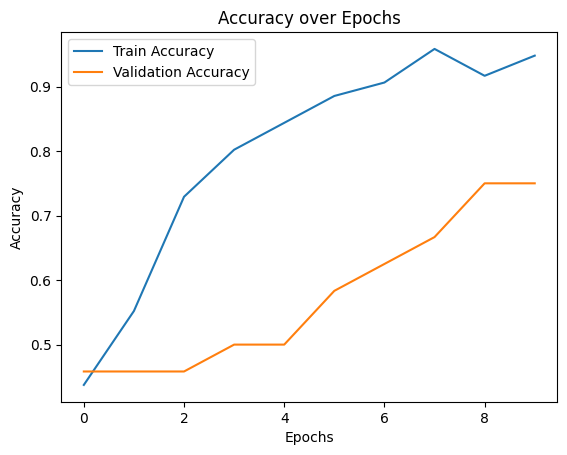

In [33]:
# Plot Training and Validation Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Training and Validation Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()